In [1]:
import os
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import preprocessing, model_selection, metrics
from zipfile import ZipFile

%matplotlib inline

## Initial Data Examination

In [2]:
data_dir = 'input_data'
file_name = "santander-value-prediction-challenge.zip"

with ZipFile(file_name, 'r') as zip_file: 
    for file in zip_file.namelist():
        if os.path.exists(data_dir + r'/' + file):
            pass
        else:
            zip_file.extract(file, data_dir)

In [3]:
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'), index_col='ID')

In [ ]:
train_df.shape

In [ ]:
train_df.head()

To begin with, looking for any observations with N/A values in train data. There do not appear to be any missing values

In [ ]:
list(filter(lambda x: x < len(train_df.columns), train_df.apply(lambda x: x.count(), axis=1)))

In [ ]:
train_df.columns

Feature names do not contain any meaningful information, so the necessary reduction of features will have to be based on on predictive relevance

Now- examining the characteristics of the target data. There is a very high range of values in the train target, with significant outliers.

In [ ]:
train_df.target.describe()

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,6))
ax1.scatter(range(train_df.shape[0]), np.sort(train_df['target'].values))
ax1.set_xlabel('Index Number', fontsize=12)
ax1.set_ylabel('Target', fontsize=12)
ax1.set_title("Target Distribution", fontsize=16)

ax2.hist(x=np.sort(train_df.target.values), bins=30)
ax2.set_xlabel('Transaction Value', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Target Histogram', fontsize=16)
plt.show()

Now, exploring transforms of target data to see if either results in a more normal distribution. Taking a log of the values helps normalize the data some, but a Box-Cox transform appears to do much better.

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5)) 
sns.distplot(np.log(train_df.target.values), bins=30, ax=ax1, kde=True).set_title('Distribution of Target Log Transform', fontsize=14)
sns.distplot(stats.boxcox(train_df.target.values)[0], bins=30, ax=ax2, kde=True).set_title('Distribution of Target Box-Cox Transform', fontsize=14)


Quickly examining the distributions of a random subsample of the feature data. Most appear to have a vast majority of zero values.

In [ ]:
fig = plt.figure(figsize=(20, 100)) 

for i, col in enumerate(train_df.iloc[:, 1:].sample(30, axis=1)):
    ax = fig.add_subplot(25, 2, i+1)
    sns.distplot(train_df[col].values, bins=10, ax = ax, kde=False).set_title('{} Distribution'.format(col))

## Feature Selection

Examing correlation between features and the target using a Spearman coefficient. Spearman's rank-order was chosen because of the extreme range of values in the target data

In [22]:
if os.path.exists(os.path.join(data_dir, 'correlation_matrix.csv')):
    correlation_matrix = pd.read_csv(os.path.join(data_dir, 'correlation_matrix.csv'), header=None, index_col=0, squeeze=True)
else:
    correlation_matrix = train_df.corr(method='spearman')['target'][1:]
    correlation_matrix.to_csv(os.path.join(data_dir, 'correlation_matrix.csv'), header=False)

In [24]:
spearman_threshold = .1
correlated_features = correlation_matrix[abs(correlation_matrix) > spearman_threshold].sort_values(ascending=False)
train_df = pd.concat([train_df.target, train_df[list(correlated_features.index)]], axis=1)

Features have been reduced to only those with an absolute Spearman correlation value of over .1, resulting a new total of 48 features. Now, examining correlation of features with one another, and removing those that have a high Spearman correlation to one another.

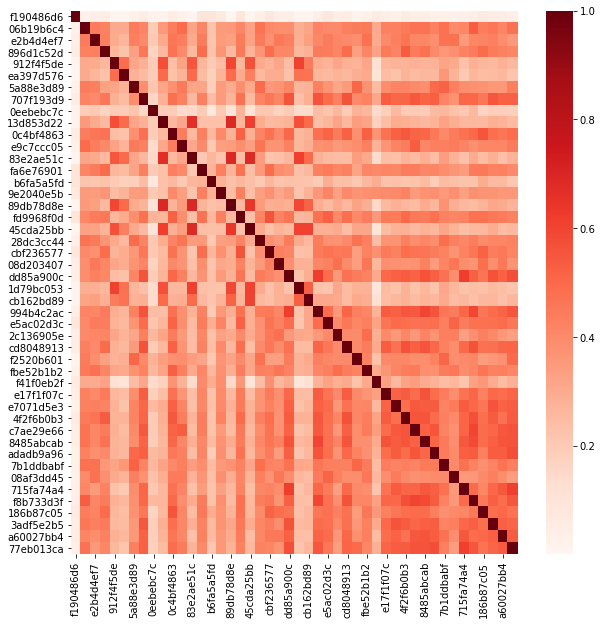

In [29]:
feature_matrix = train_df.iloc[:, 1:].corr(method='spearman').abs()
plt.figure(figsize=(10,10))
sns.heatmap(feature_matrix, cmap='Reds')

In [26]:
columns = np.full((feature_matrix.shape[0],), True, dtype=bool)

for i in range(feature_matrix.shape[0]):
    for j in range(i+1, feature_matrix.shape[0]):
        if feature_matrix.iloc[i,j] >= 0.7:
            if columns[j]:
                columns[j] = False
                
selected_columns = train_df.iloc[:, 1:].columns[columns]
train_df = pd.concat((train_df['target'], train_df[selected_columns]), axis=1)

Features have been further reduced based on their Spearman correlation to one another. Only two features had a coefficient of over .7, so the feature count is now 46. 

## Feature and Target Transformations

Now that the features have been reduced, I am exploring the relationships between features and the target, as well as possible transformations prior to modeling. 

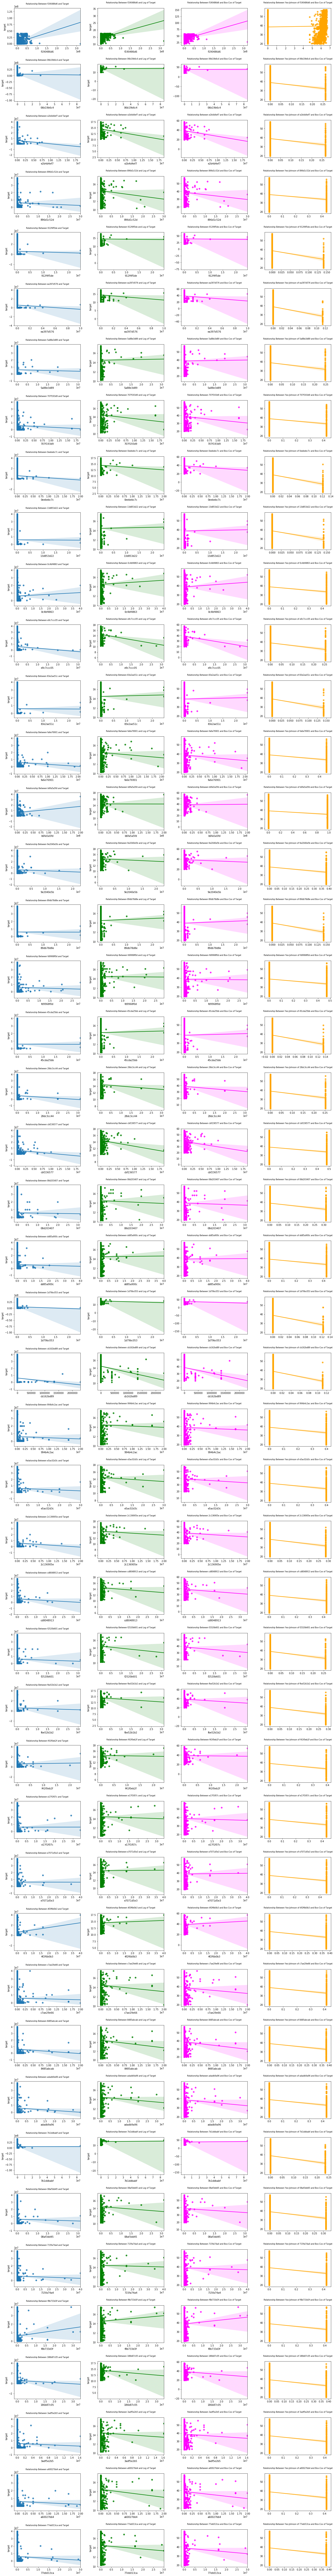

In [27]:
fig, axs = plt.subplots(ncols=4, nrows=len(train_df.columns[1:]), figsize=(20, 150))

for i, col in enumerate(train_df.iloc[:, 1:]):
    sns.regplot(train_df[col], train_df['target'], ax=axs[i, 0]).set_title('Relationship Between {} and Target'.format(col), fontsize=8, pad=15)
    sns.regplot(train_df[col], np.log(train_df['target']), ax=axs[i, 1], color='green').set_title('Relationship Between {} and Log of Target'.format(col), fontsize=8, pad=20)
    sns.regplot(train_df[col], stats.boxcox(train_df['target'])[0], ax=axs[i, 2], color='magenta').set_title('Relationship Between {} and Box-Cox of Target'.format(col), fontsize=8, pad=20)
    sns.regplot(stats.yeojohnson(train_df[col])[0], stats.boxcox(train_df['target'])[0], color='orange', ax=axs[i, 3]).set_title('Relationship Between Yeo-Johnson of {} and Box-Cox of Target'.format(col), fontsize=8, pad=20)

fig.tight_layout(pad=2.0)


Here i opt to normalize the features, using a Yeo-Johnson transform, to account for negative values, and the target, using a Box-Cox method.

In [ ]:
power = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
train_df_trans = power.fit_transform(train_df.iloc[:, 1:].values)

train_df.iloc[:, 1:] = train_df_trans
train_df['target'] = stats.boxcox(train_df['target'])[0]


In [ ]:
train_df.to_csv(os.path.join(data_dir, 'train_preprocessed.csv'))

# ONLY WHEN FINISHED

In [ ]:
# Cleaning up saved data files
import shutil

shutil.rmtree(data_dir)